In [1]:
from modules.base import *

#### Map-Reduce

- 여러가지 선택지 중 하나 선택하는 형태 구현

- 인덱싱을 위해 pydantic 활용

---

In [2]:
translation_prompt = """아래 한국어 내용을 3가지 방식으로 영어로 번역해주세요.

번역할 내용:
{messages}

영어로 번역한 내용 3가지:"""

summary_prompt = """please summarize the following messages in English.

{translation}

summary:"""

select_best_summary_prompt = """다음 영어 요약들중에 가장 올바르게 요약된 것을 선택하세요.

한국어 내용 : 
{messages}

영어 요약들 : 
{summaries}

요약의 ID는 0부터 시작합니다.
"""

In [3]:
# pydantic
class TranslationState(BaseModel):
    translations_lst: list[str] # 번역 리스트

class SummaryState(BaseModel):
    summary: str # 요약 내용
    
class BestSummary(BaseModel):
    id: int # 요약 중 가장 올바른 텍스트의 인덱스

# 기본 상태
class OverallState(TypedDict):
    messages: str # 사용자 입력
    translation: str # 번역내용
    translations_lst: Annotated[list, add] # 번역 리스트
    summary_lst: Annotated[list, add] # 요약 리스트
    best_selected_summary: str # 요약 중 가장 올바른 텍스트

In [4]:
@trace_function(only_func_name=False, print_json_format=True)
def node_generate_translations(state: OverallState):
    prompt = translation_prompt.format(messages=state["messages"])
    response = llm.with_structured_output(TranslationState).invoke(prompt)
    return {"translations_lst": response.translations_lst}

@trace_function(only_func_name=False, print_json_format=True)
def continue_to_summary(state: OverallState):
    return [Send("node_generate_summary", {"translation": s}) for s in state["translations_lst"]]

@trace_function(only_func_name=False, print_json_format=True)
def node_generate_summary(state: OverallState):
    prompt = summary_prompt.format(translation=state["translation"])
    response = llm.with_structured_output(SummaryState).invoke(prompt)
    return {"summary_lst": [response.summary]}

@trace_function(only_func_name=False, print_json_format=True)
def node_best_summary(state: OverallState):
    summaries = "\n\n".join(state["summary_lst"])
    prompt = select_best_summary_prompt.format(messages=state["messages"], 
                                               summaries=summaries)
    response = llm.with_structured_output(BestSummary).invoke(prompt)
    return {"best_selected_summary": state["summary_lst"][response.id]}

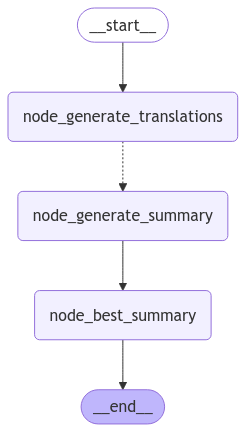

In [5]:
builder = StateGraph(OverallState)
builder.add_node("node_generate_translations", node_generate_translations)
builder.add_node("node_generate_summary", node_generate_summary)
builder.add_node("node_best_summary", node_best_summary)
builder.add_edge(START, "node_generate_translations")
builder.add_conditional_edges("node_generate_translations", continue_to_summary, ["node_generate_summary"])
builder.add_edge("node_generate_summary", "node_best_summary")
builder.add_edge("node_best_summary", END)
graph = builder.compile()
Image(graph.get_graph().draw_mermaid_png())

In [6]:
graph.invoke({"messages": "고래는 해양 포유류로, 바다에 살면서도 육지 동물처럼 허파로 호흡을 합니다. 고래는 크게 이빨고래와 수염고래로 나눌 수 있습니다. 고래는 크기가 매우 다양하며, 세계에서 가장 큰 동물인 **대왕고래(블루웨일)**는 길이가 약 30미터에 달할 수 있습니다. 사회적이고 지능이 높은 동물로, 의사소통과 협동 사냥을 하는 경우도 많습니다."})


🚀 Passing Through [node_generate_translations] ..

#### [Input State]
args: [
    {
        "messages": "고래는 해양 포유류로, 바다에 살면서도 육지 동물처럼 허파로 호흡을 합니다. 고래는 크게 이빨고래와 수염고래로 나눌 수 있습니다. 고래는 크기가 매우 다양하며, 세계에서 가장 큰 동물인 **대왕고래(블루웨일)**는 길이가 약 30미터에 달할 수 있습니다. 사회적이고 지능이 높은 동물로, 의사소통과 협동 사냥을 하는 경우도 많습니다.",
        "translations_lst": [],
        "summary_lst": []
    }
]

#### [Output State]
result: {
    "translations_lst": [
        "Whales are marine mammals that live in the sea but breathe with lungs like land animals. Whales can be broadly classified into toothed whales and baleen whales. They vary greatly in size, with the blue whale, the largest animal in the world, reaching lengths of up to 30 meters. Whales are social and intelligent creatures, often engaging in communication and cooperative hunting.",
        "Whales, as marine mammals, inhabit the ocean but breathe through lungs similar to terrestrial animals. They can be categorized into two main groups: toothed whales and baleen whales

{'messages': '고래는 해양 포유류로, 바다에 살면서도 육지 동물처럼 허파로 호흡을 합니다. 고래는 크게 이빨고래와 수염고래로 나눌 수 있습니다. 고래는 크기가 매우 다양하며, 세계에서 가장 큰 동물인 **대왕고래(블루웨일)**는 길이가 약 30미터에 달할 수 있습니다. 사회적이고 지능이 높은 동물로, 의사소통과 협동 사냥을 하는 경우도 많습니다.',
 'translations_lst': ['Whales are marine mammals that live in the sea but breathe with lungs like land animals. Whales can be broadly classified into toothed whales and baleen whales. They vary greatly in size, with the blue whale, the largest animal in the world, reaching lengths of up to 30 meters. Whales are social and intelligent creatures, often engaging in communication and cooperative hunting.',
  'Whales, as marine mammals, inhabit the ocean but breathe through lungs similar to terrestrial animals. They can be categorized into two main groups: toothed whales and baleen whales. Whales exhibit significant size variation, with the blue whale, the largest animal globally, potentially reaching a length of approximately 30 meters. Known for their social nature and high intelligence, w